# Google Colab Setup

In [0]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/amld20-text-classification.git
        
    # Copy files required to run the code
    !cp -r "amld20-text-classification/data" "amld20-text-classification/tools.py" .
    
    # Install packages via pip
    !pip install -r "amld20-text-classification/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

Cloning into 'amld20-text-classification'...
remote: Enumerating objects: 6081, done.
remote: Counting objects: 100% (6081/6081), done.
remote: Compressing objects: 100% (5629/5629), done.
remote: Total 6081 (delta 454), reused 6077 (delta 450), pack-reused 0
Receiving objects: 100% (6081/6081), 12.58 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (454/454), done.


# Text classification :: Spam detection

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

## 1. The data

In [0]:
# Load libraries and helper functions

import tools

In [2]:
# Load the data

df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's have a look at a few rows from the dataset.

***Note:*** *label* is 0 for *non-spam* and 1 for *spam*.

In [3]:
df.sample(3)

,label,text
1081,1,"My FREE Media Sofware link enjoy, Jim---> http://www.freeoptmail3.com/jimmy/plugin.html <a href=http://www.freeoptmail3.com/jimmy/plugin.html>Click here to go to the site</a> Personal Quote: All for one and one for all. This is not a spam email. This email was sent to you because your email was entered in on a website requesting to be a registered subscriber. <a href=mailto:e-removes@btamail.cn.net>click here to cancel your account</a> and you will never receive another email from us! Please add remove in the subject line. tgwwcvwledqaerisufctgsfkf"
879,1,"The Magical Solution that Triples Index Annuity Sales! As a unique promotional opportunity, there is currently no charge for our ""Big-Hitter Sales Tool Combination"" (for the first 199 respondents only). This ""Magic Solution"" is already responsible for countless millions of dollars in Index Annuity premium and Agent Sales Commissions. You honestly will not believe how simple and easy this makes selling Index Annuities. It is literally like falling off a log. As one rep stated, ""You don't even have to do anything different than you already are doing...it just kind of happens...Kicks-in and starts generating new clients and uncovering assets just like magic!"" To claim your free Report and Bonus Audiotape, simply call our 24-hour automated response line! Simple and painless. Call anytime (but be one of the first 199), the response line is fully automated and works 24/7. Or, you can quickly fill out the form below. _____ Call today to receive this free report and audiotape! 800-436-1631 ext 86055 ? or can complete the form below ? Name: Address: City: State: Zip: E-mail: Phone: Fax: USA Financial - www.usa-financial.com <http://www.usa-financial.com> We don't want anyone to receive our mailings who does not wish to. This is professional communication sent to insurance professionals. To be removed from this mailing list, DO NOT REPLY to this message. Instead, go here: http://www.Insurancemail.net <http://www.Insurancemail.net> Legal Notice <http://www.insuranceiq.com/legal.htm>"
2639,0,"URL: http://www.newsisfree.com/click/-2,8430044,215/ Date: 2002-10-01T12:41:57+01:00 *Live online:* The Observer's *Tracy McVeigh* and experts *Tim Brighouse* and * Ann Hodgson* will be here on Thursday at 3pm to discuss the government's record. Post your questions now."


Now, let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




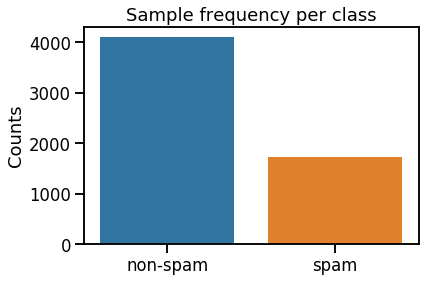

In [4]:
tools.plot_class_frequency(df)

## 2. Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

**Take a few minutes to look at the raw text. What do you think should be removed from the text?**

Below are a few pointers:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespace
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

The *clean_corpus* function below takes care of all of that!

In [5]:
df = tools.clean_corpus(df)

print('Data cleaned')

Data cleaned


Let's have a look at a few "cleaned" examples.

In [6]:
tools.show_clean_text(df)


Original document:

URL: http://www.newsisfree.com/click/-0,8613679,159/ Date: 2002-10-06T18:12:41+01:00 Rendering
engines used in todays game titles utilize various techniques for hidden surface removal (HSR),
different techniques being suitable for different game genres. For example, action games played in
closed-in locations need an engine allowing fast rendering of a few hundred polygons, a high frame
rate, and a high level of details to impress players. Conversely, a game that is taking place
outdoors requires quite a different approach. This features present one one technique for hidden
surface removal usable in 3D engines using tilizing object occlusion.

Cleaned document:

date rendering engines used todays game titles utilize various techniques hidden surface removal
different techniques suitable different game genres example action games played closed locations
need engine allowing fast rendering polygons high frame rate high level details impress players
conversely game ta

## 3. Data Exploration :: What makes spam distinct?

### 2.1 Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the most frequent words in spam and non-spam.

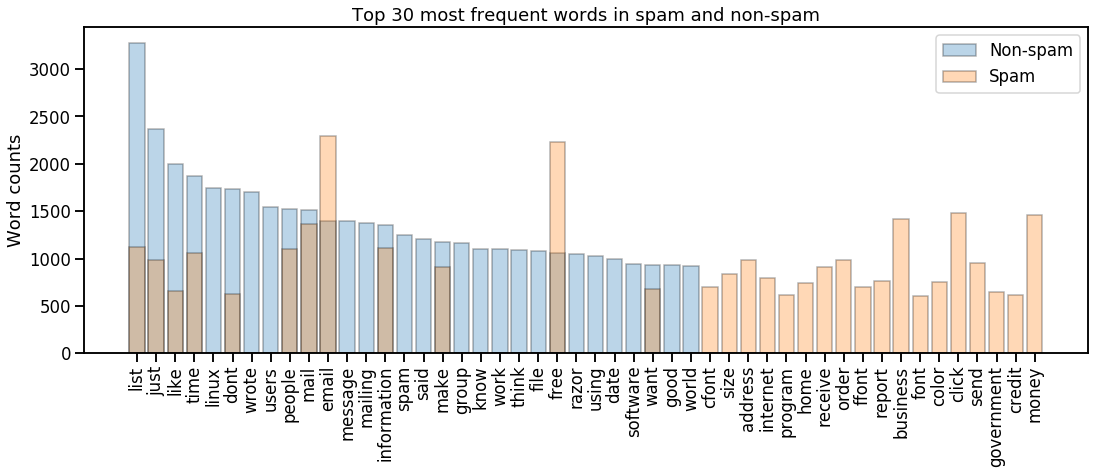

In [7]:
tools.plot_most_common_words(df=df, N=30)

**Frequent "spammish" words**: 

* click
* money
* business
* free
* email
* ...

**Frequent "non-spammish" words**:
* list
* linux
* message
* wrote
* users
* spam
* said
* file
* good
* ...

### 2.2 What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

In [0]:
features = tools.get_features(df=df)

## 3. Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [8]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## 4. Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, we need to split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. The test set will be used to `evaluate` the performance of our model. 

### 4.1 Spam classification

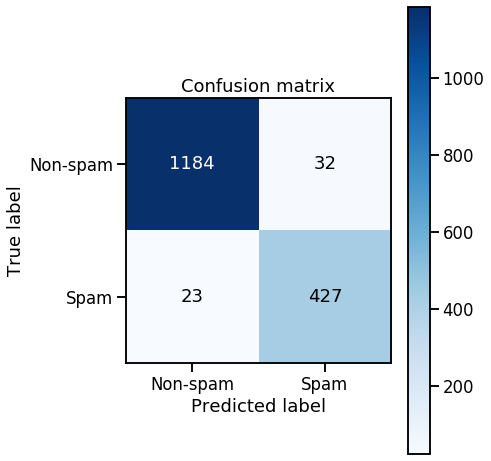

In [9]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data

# 
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test,model);


def fit_model(df_train):
    
    '''
    This function performs the following:
    - extracts BoW features from train data
    - fits a LogReg model.
    
    **Note**: The model parameters were optimized with GridSearchCV 
              in a previous calculation to maximize f1-score on the 
              validation splits (cv=5).
    '''

    # Train set: features
    X_train = df_train['text_cleaned'].values

    # Train set: Labels
    y_train = df_train['label'].values

    # Define pipeline
    model = Pipeline([('vectorizer',CountVectorizer()),
                      ('lr',LogisticRegression(solver='liblinear',
                                               class_weight='balanced',
                                               random_state=None))]) 

    ## Optimized parameters ##
    ## -------------------- ##
    ## Note: Params optimized for maximizing f1-score for validation splits (cv = 5)
    optimized_params = {'lr__C': 0.1, 'vectorizer__max_features': 20000, 
                        'vectorizer__min_df': 2, 
                        'vectorizer__ngram_range': (1, 1)}

    model.set_params(lr__C = optimized_params['lr__C'],
                     vectorizer__max_features = optimized_params['vectorizer__max_features'],
                     vectorizer__min_df = optimized_params['vectorizer__min_df'],
                     vectorizer__ngram_range = optimized_params['vectorizer__ngram_range'])

    # Fit model
    model.fit(X_train,y_train)

    return model

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation]((https://en.wikipedia.org/wiki/Confusion_matrix))).

* The first row represents non-spam mails: 1'187 were correctly classified as 'non-spam', while 29 (~2,3%) were misclassified as 'spam'.
* The second row represents spam mails: 437 were correctly classified as 'spam', while 13 (~2,8%) were misclassified as 'non-spam'.

Our model did quite well!

In [10]:
df_train.head()

,label,text,text_cleaned
24,1,"Dear Sir / Madam If you are fed up of being 'ripped off' by the British government every time you buy your tobacco, then you should visit our website, where you can now buy 4 cartons of cigarettes, or 40 pouches of rolling tobacco from as little as 170 Euros (approx 105 pounds), inclusive of delivery by registered air mail from our office in Spain. Why pay more??? Visit our website at http://www.smokesdirect.com/?ID=2 Best regards Sales Department Smokes Direct Spain xay2095811y -- Irish Linux Users' Group: ilug@linux.ie http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information. List maintainer: listmaster@linux.ie",dear madam ripped british government time tobacco visit website cartons cigarettes pouches rolling tobacco little euros approx pounds inclusive delivery registered mail office spain visit website best regards sales department smokes direct spain xayy irish linux users group subscription information list maintainer
1952,0,"http://news.bbc.co.uk/1/hi/world/asia-pacific/2220132.stm Tuesday, 27 August, 2002, 21:35 GMT 22:35 UK Cambodia temple ruins yield treasure Workers clearing dense jungle near the ruins of an ancient pagoda in northern Cambodia have unearthed 31 Buddha statues - 27 of them solid gold. The statues - which are 10 centimetres (4 inches) tall - are in good condition and believed to be hundreds of years old. They were found on Saturday as workers were rebuilding the Po Pich temple about 100 km (65miles) north of the capital, Phnom Penh. The pagoda, in the Batay district of Kampong Thom province, was torn down during the reign of the Khmer Rouge in the 1970s and the area became overgrown. Community care Deputy police chief of Kampong Thom province, Hang Sithim, said the statues - three of which were silver and one bronze - were buried in about one metre (3.4ft) of earth and each weigh around 500 grams (1lb). ''I think that these Buddha statues had been buried hundreds of years ago, when the last temple was fully operating,"" Mr Hang Sithim said. Provincial authorities initially planned to take the statues to a nearby town for safekeeping, but opted to allow the Buddhist community at the temple to take care of them. ''We believe they are safe there,'' said Som Somphat, deputy governor of Kampong Thom province. ''The people of Po Pich pledged to treat them with respect and honour.'' Reign of terror A police guard has been placed around the site to protect it from looters. The Khmer Rouge waged civil war in Cambodia between 1970 and 1998 and controlled the country between 1975 and 1979. The regime outlawed religion and destroyed many objects regarded as decadent or culturally impure. About two million people died in the Khmer Rouge's drive to turn Cambodia into a farmers' utopia. ------------------------ Yahoo! Groups Sponsor ---------------------~--> 4 DVDs Free +s&p Join Now http://us.click.yahoo.com/pt6YBB/NXiEAA/MVfIAA/7gSolB/TM ----------------------------------------...",tuesday august cambodia temple ruins yield treasure workers clearing dense jungle near ruins ancient pagoda northern cambodia unearthed buddha statues solid gold statues centimetres inches tall good condition believed hundreds years saturday workers rebuilding pich temple miles north capital phnom penh pagoda batay district kampong thom province torn reign khmer rouge area overgrown community care deputy police chief kampong thom province hang sithim said statues silver bronze buried metre earth weigh grams think buddha statues buried hundreds years temple fully operating hang sithim said provincial authorities initially planned statues nearby town safekeeping opted allow buddhist community temple care believe safe said somphat deputy governor kampong thom province people pich pledged treat respect honour reign terror police guard placed site protect looters khmer rouge waged civil cambodia controlled country regime outlawed religion destroyed objects regarded decadent culturally impure 

### 4.2 What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

**PS: This is a Pareto plot of logistic regression coefficients.**

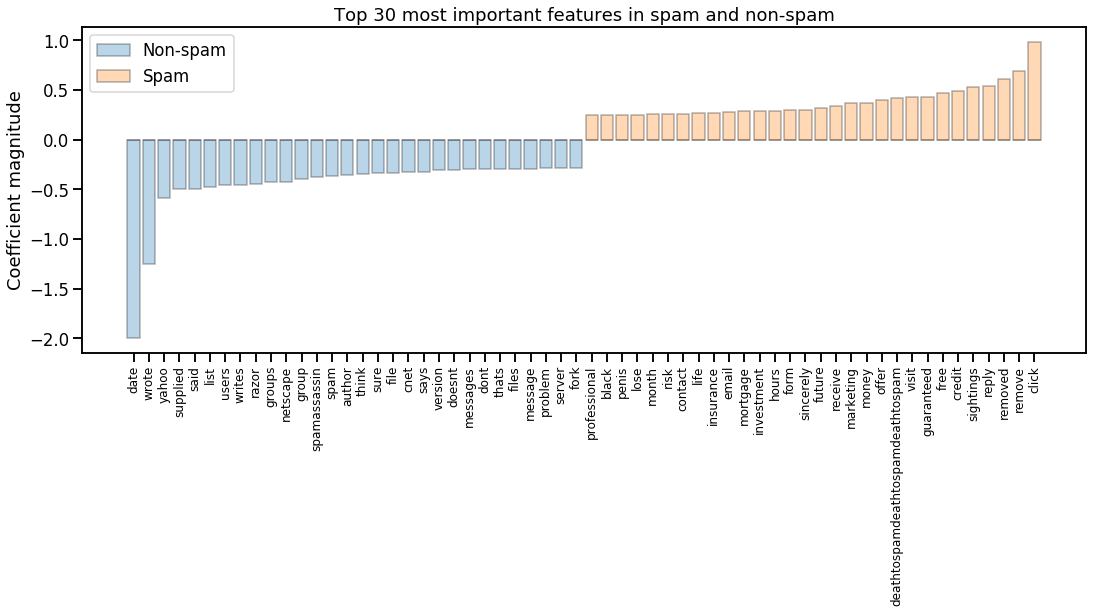

In [11]:
tools.visualize_coefficients(model, n_top_features=30)

According to the model, words such as "date", "wrote", "yahoo", "said", "linux", "author", ... are strong indicators of non-spam.  

Words such as "click", "credit", "remove", "free", "offer", "money" ... indicate spam. 

In [15]:
coefficients  = model.named_steps['lr'].coef_
type(coefficients)
coefficients.shape

(1, 19394)

### 4.3 Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 16 


Original Text
----- Original Message ----- From: "R. A. Hettinga" <rah@shipwright.com> > > > > "Free trade and
free markets have proven their ability to lift whole > > societies out of poverty" > > I'm not a
socio-political/history buff - does anybody have some clear > > examples? > > You're probably living
in one, or you wouldn't be able to post here. > When was the whole US society in poverty & was that
before free trade & free markets? I'm looking for transitions due to free xyz. 


Cleaned text
original message hettinga free trade free markets proven ability lift societies poverty socio
political history buff does anybody clear examples youre probably living wouldnt able post society
poverty free trade free markets looking transitions free 


Actual class:     Non-spam
Predicted class:  Spam 


Predicted probabilities

Non-spam:   0.3937
Spam:       0.6063



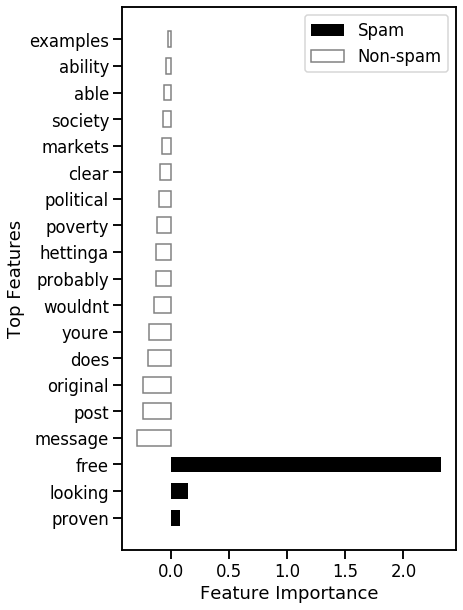

In [16]:
tools.error_analysis(df_test,model,doc_nbr=16)